In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13
cosmo = Planck13

In [41]:
os.chdir("/home/mitchell/Documents/masters/masters/data/server/run_41/outputs")
os.getcwd()
output = np.loadtxt('output_342000_pairs.txt',delimiter=',')

'/home/mitchell/Documents/masters/masters/data/server/run_41/outputs'

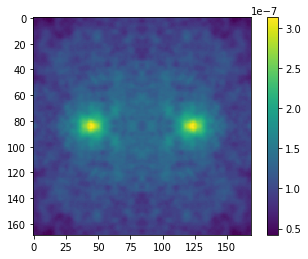

In [44]:
plt.imshow(output)
plt.colorbar()

In [54]:
mask = np.zeros_like(output)
import scipy.ndimage
mask[:,:] = 1    
width = 30
mask[width:(169-width),width:(169-width)] = 0
index = np.unique(mask)
annular_mean = sp.ndimage.mean(output,labels = mask)
print(annular_mean)

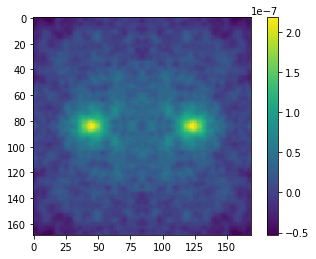

In [56]:
plt.imshow(output[:,:]-annular_mean)
plt.colorbar()

In [48]:
centre = int(len(output)/2)+1
print(centre)
central_line_x = output[centre,:]
central_line_y = output[:,centre]

85


In [49]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2)))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2))) +\
           amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen2)**2)/((2*sigma2)**2)))

In [50]:
y_array_2gauss = central_line_x
x_array = np.arange(len(central_line_x))

In [57]:
amp1 = 3e-7
cen1 = 48.0
sigma1 = 5
amp2 = 3e-7
cen2 = 125
sigma2 = 5

In [58]:
popt_2gauss, pcov_2gauss = sp.optimize.curve_fit(_2gaussian, x_array, y_array_2gauss, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
gauss_peak_1 = _1gaussian(x_array, *pars_1)
gauss_peak_2 = _1gaussian(x_array, *pars_2)

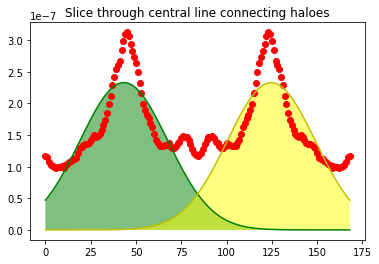

In [59]:
plt.plot(central_line_x,'ro')
plt.title("Slice through central line connecting haloes")
# plt.savefig("Central_Slice")
plt.plot(x_array, gauss_peak_1, "g")
plt.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
plt.plot(x_array, gauss_peak_2, "y")
plt.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5) 

In [15]:
pars_1

array([1.35857733e-05, 4.16067696e+01, 1.53805392e+01])

In [16]:
pars_2

array([1.64845180e-05, 1.23134811e+02, 1.89869615e+01])

In [17]:
os.chdir('/home/mitchell/Documents/masters/masters/data/')
glob.glob('*')

['spt_sz_DES_catalogue.pkl',
 'galaxy_pairs.pkl',
 'cut_catalogue.pkl',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_090ghz.h5',
 'source_J2341_5119_90ghz.png',
 'unphysical_cat_2.pkl',
 'pairs.csv',
 'unphysical_cat_4.pkl',
 'DES_REDMAGIC_Manipulated.csv',
 'y_map.npy',
 'ra0dec-57p5_sum1000_090ghz.h5',
 'ra0dec-57p5_sum5000_150ghz.h5',
 'compton_y_map.png',
 'source_J2341_5119_150ghz.png',
 'high_res_map.png',
 'unphysical_pairs_4.pkl',
 'y_map.h5',
 'high_res.h5',
 'unphysical_cat_3.pkl',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_150ghz.h5',
 'unphysical_pairs_3.pkl',
 'Redshift_Distribution.png',
 'ra0dec-57p5_sum100Weighted_150ghz.h5',
 'LOS_Separation.png',
 'cr_coadds',
 'redmagic_sva1_public_v6.3_faint.fits',
 'sri_J2337_5942_diff.png',
 'ra0dec-57p5_sum1000_150ghz.h5',
 'source_2337_5942_90ghz.png',
 'scratch',
 'ra0dec-57p5_sum_150ghz.h5',
 'Run_1',
 'planck2015',
 'ra0dec-57p5_sum100Weighted_090ghz.h5',
 'sri_J2337_5942_150ghz.png',
 'first_coadd_test_fbcode.h5',
 'simulate

In [18]:
pairs = pd.read_pickle('spt_pol_galaxy_pairs.pkl')

In [19]:
cat = pd.read_pickle('spt_pol_DES_catalogue.pkl')

In [20]:
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')

/home/mitchell/Software/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


DescribeResult(nobs=342014, minmax=(0.15010099112987518, 0.8997664749622345), mean=0.46894798573542806, variance=0.01736099065107964, skewness=-0.15925775471498915, kurtosis=-0.10621488515786215)

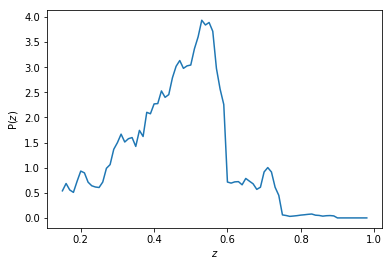

In [21]:
mean_redshift = np.mean([pairs.Z1,pairs.Z2],axis=0)
redshift_pdf = plt.hist(mean_redshift,normed=True,cumulative=False,label='Redshift PDF', histtype = 'step'
                        , alpha = 0.8,color = 'k',bins=np.arange(0.15,1.0,0.01))
plt.close()
plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],redshift_pdf[0])
plt.xlabel('$z$')
plt.ylabel('P($z$)')
plt.savefig('Redshift_Distribution.png')
sp.stats.describe(mean_redshift)

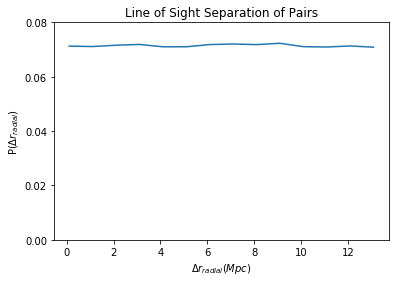

In [22]:
sep_los_pdf = plt.hist(pairs.SEP_LOS, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(0.1,14.5,1))
plt.close()
plt.plot(sep_los_pdf[1][:len(sep_los_pdf[0])],sep_los_pdf[0])
plt.xlabel('$\Delta r_{radial} (Mpc)$')
plt.ylabel('P($\Delta r_{radial}$)')
plt.ylim([0.0,0.08])
plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Line of Sight Separation of Pairs')
plt.savefig('LOS_Separation.png')

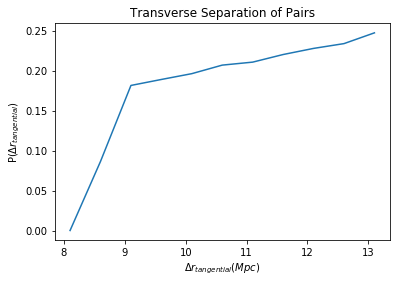

In [23]:
sep_trv_pdf = plt.hist(pairs.SEP_TRV, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(8.1,14.1,0.5))
plt.close()
plt.plot((sep_trv_pdf[1][:len(sep_trv_pdf[0])]),sep_trv_pdf[0])
plt.xlabel('$\Delta r_{tangential} (Mpc)$')
plt.ylabel('P($\Delta r_{tangential}$)')
# plt.ylim([0.0,0.08])
# plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Transverse Separation of Pairs')
plt.savefig('TRV_Separation.png')

In [24]:
cat.ZREDMAGIC.describe()

count    99609.000000
mean         0.515210
std          0.159174
min          0.150070
25%          0.405930
50%          0.518504
75%          0.620101
max          0.899987
Name: ZREDMAGIC, dtype: float64

In [25]:
sp.stats.describe(np.rad2deg(pairs.DEL_THETA)*60)

DescribeResult(nobs=342014, minmax=(9.987826562903068, 109.7429491720855), mean=31.587073542178825, variance=170.14505158796285, skewness=1.7588691994641599, kurtosis=4.482165807743133)

In [26]:
sp.stats.describe(pairs.Sep*cosmo.h)

DescribeResult(nobs=342014, minmax=(6.009578555486666, 17.20183485873439), mean=11.915994973792692, variance=5.545770151833718, skewness=-0.26837695649171506, kurtosis=-0.6073201055682458)